In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Sentiment Analysis de valoraciones de Películas con Decision Tree y Random Forest

In [4]:
imdb=pd.read_csv('csv/Train.csv')
print(imdb.info())
print(imdb.shape)
print(imdb.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None
(40000, 2)
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
5  A terrible movie as everyone has said. What ma...      0
6  Finally watched this shocking movie last night...      1
7  I caught this film on AZN on cable. It sounded...      0
8  It may be the remake of 1987 Autumn's Tale aft...      1
9  My Super Ex Girlfriend turned out to be a plea...      1


Primero reduciremos el volumen de datos hasta el 10% para acelerar el proceso. De los datos restantes nos quedaremos con el 50% para entrenamiento y el otro 50% el 25% será para testeo y validación.

In [5]:
from sklearn.model_selection import train_test_split

features = imdb.drop("label",axis=1)
labels = imdb["label"]

X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.90, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size = 0.5, random_state=42)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train),len(y_val),len(y_test)))

Data distribution:
- Train: 2000 
- Validation: 1000 
- Test: 1000



La siguiente función preprocesará los textos de las valoraciones. Lo que hará será:
* Tokenizar los textos
* Eliminar las mayúsculas
* Eliminar las stopwords
* Eliminar los caracteres no alpha-numéricos
* Lematizar las palabras

In [6]:
def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

A continuación visualizamos las palabras más comunes en las reveiews positivas y negativas respectivamente.

Processing data...
Creating word clouds...


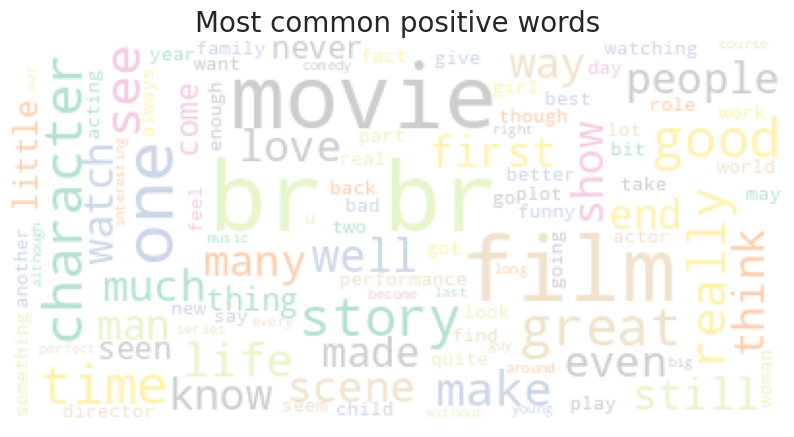

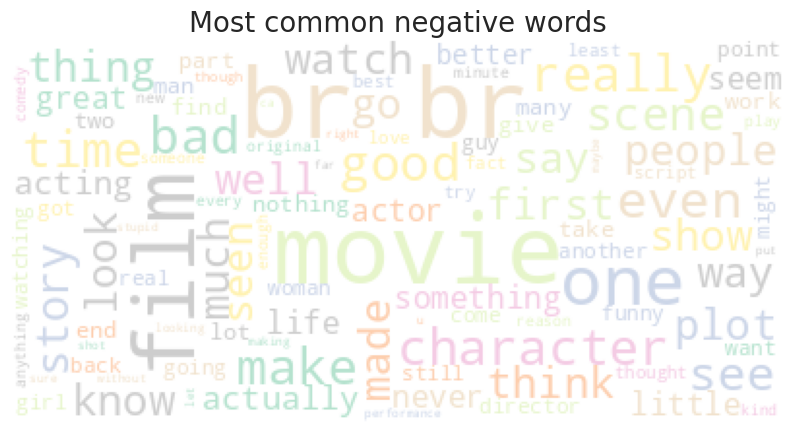

In [7]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(10,8))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')
    
imdb=imdb.head(1000)
print("Processing data...")
imdb['clean']=imdb['text'].map(clean)
imdb['clean_text']=imdb['clean'].apply(lambda x: " ".join([str(word) for word in x]))

print("Creating word clouds...")
positive_words=" ".join(imdb[imdb.label==1]['clean_text'].values)
negative_words=" ".join(imdb[imdb.label==0]['clean_text'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")

Aplicamos Tf-idf a los datos

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [9]:
tfidf_vect = TfidfVectorizer(analyzer=clean)
tfidf_vect_fit = tfidf_vect.fit(X_train['text'])
X_train = vectorize(X_train['text'],tfidf_vect_fit)

# Primera aproximación al modelo de Decision Tree sin hiperparámetros con el método de validación cruzada.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt = DecisionTreeClassifier()
scores = cross_val_score(dt,X_train,y_train.values.ravel(),cv=5)

In [11]:
print(scores)
scores.mean()

[0.6575 0.6625 0.6275 0.6675 0.64  ]


0.651

Ahora haremos un barrido de hiperparámetros.

In [12]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [13]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier()
parameters = {
    'max_leaf_nodes': [5,10,20,40,80],
    'max_depth': [2,5,8,10,20,30,None]
}

cv = GridSearchCV(dt,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': 8, 'max_leaf_nodes': 10}

0.622 (+/-0.028) for {'max_depth': 2, 'max_leaf_nodes': 5}
0.622 (+/-0.028) for {'max_depth': 2, 'max_leaf_nodes': 10}
0.622 (+/-0.027) for {'max_depth': 2, 'max_leaf_nodes': 20}
0.622 (+/-0.027) for {'max_depth': 2, 'max_leaf_nodes': 40}
0.622 (+/-0.027) for {'max_depth': 2, 'max_leaf_nodes': 80}
0.659 (+/-0.033) for {'max_depth': 5, 'max_leaf_nodes': 5}
0.657 (+/-0.053) for {'max_depth': 5, 'max_leaf_nodes': 10}
0.653 (+/-0.048) for {'max_depth': 5, 'max_leaf_nodes': 20}
0.656 (+/-0.046) for {'max_depth': 5, 'max_leaf_nodes': 40}
0.653 (+/-0.043) for {'max_depth': 5, 'max_leaf_nodes': 80}
0.659 (+/-0.033) for {'max_depth': 8, 'max_leaf_nodes': 5}
0.673 (+/-0.056) for {'max_depth': 8, 'max_leaf_nodes': 10}
0.659 (+/-0.055) for {'max_depth': 8, 'max_leaf_nodes': 20}
0.658 (+/-0.044) for {'max_depth': 8, 'max_leaf_nodes': 40}
0.656 (+/-0.047) for {'max_depth': 8, 'max_leaf_nodes': 80}
0.659 (+/-0.033) for {'max_depth': 10, 'max_leaf_n

In [14]:
X_val=vectorize(X_val['text'],tfidf_vect_fit)

In [15]:
dt1 = DecisionTreeClassifier(max_leaf_nodes=5,max_depth=None)
dt1.fit(X_train, y_train.values.ravel())
dt2 = DecisionTreeClassifier(max_leaf_nodes=10,max_depth=8)
dt2.fit(X_train, y_train.values.ravel())
dt3 = DecisionTreeClassifier(max_leaf_nodes=40,max_depth=20)
dt3.fit(X_train, y_train.values.ravel())

DecisionTreeClassifier(max_depth=20, max_leaf_nodes=40)

In [16]:
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score

for mdl in [dt1,dt2,dt3]:
    y_pred = mdl.predict(X_val)
    f1 = round(f1_score(y_val, y_pred), 3)
    accuracy = round(accuracy_score(y_val,y_pred), 3)
    precision = round(precision_score(y_val,y_pred), 3)
    recall = round(recall_score(y_val,y_pred), 3)
    print('MAX DEPTH: {} / MAX LEAF NODES: {} -- F1: {} / Accuracy: {} / Precision: {} / Recall: {}'.format(mdl.max_depth,
                                                                         mdl.max_leaf_nodes,
                                                                         f1,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

MAX DEPTH: None / MAX LEAF NODES: 5 -- F1: 0.746 / Accuracy: 0.703 / Precision: 0.641 / Recall: 0.894
MAX DEPTH: 8 / MAX LEAF NODES: 10 -- F1: 0.742 / Accuracy: 0.72 / Precision: 0.676 / Recall: 0.822
MAX DEPTH: 20 / MAX LEAF NODES: 40 -- F1: 0.727 / Accuracy: 0.719 / Precision: 0.692 / Recall: 0.767


**MAX DEPTH: 8 / MAX LEAF NODES: 10**

Ahora evaluaremos con el mejor modelo el set de testeo.

MAX DEPTH: 20 / MAX LEAF NODES: 40 -- F1: 0.466 / Accuracy: 0.702 / Precision: 0.668 / Recall: 0.754
[[0.65384615 0.34615385]
 [0.24583333 0.75416667]]


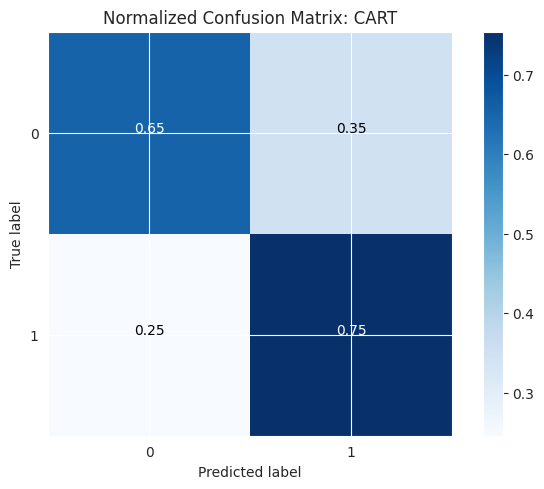

In [17]:
X_test=vectorize(X_test['text'],tfidf_vect_fit)

y_pred = dt3.predict(X_test)
f1 = round(f1_score(y_val, y_pred), 3)
accuracy = round(accuracy_score(y_test,y_pred), 3)
precision = round(precision_score(y_test,y_pred), 3)
recall = round(recall_score(y_test,y_pred), 3)
print('MAX DEPTH: {} / MAX LEAF NODES: {} -- F1: {} / Accuracy: {} / Precision: {} / Recall: {}'.format(dt3.max_depth,
                                                                         dt3.max_leaf_nodes,
                                                                         f1,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_pred),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: CART')

Palabras más relevantes a la hora de predecir la clase correcta.

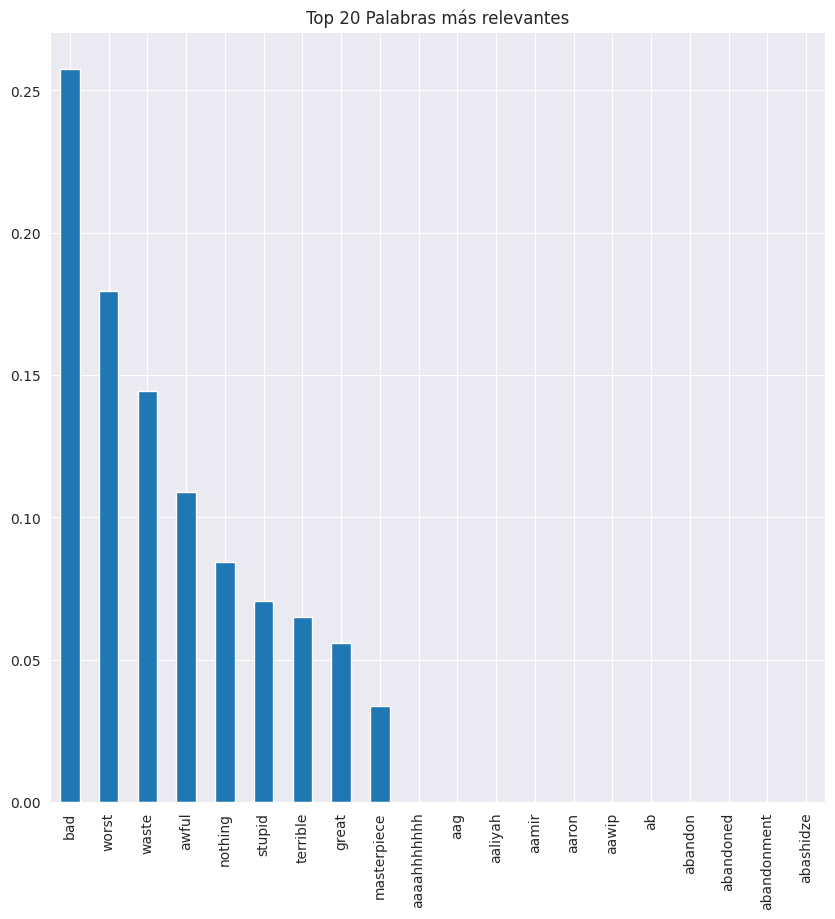

In [18]:
feat_importances = pd.Series(dt2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='bar', figsize=(10, 10))
plt.title("Top 20 Palabras más relevantes")
plt.show()

# Primera aproximación al modelo de Random Forest sin hiperparámetros con el método de validación cruzada.

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
scores = cross_val_score(rf,X_train,y_train.values.ravel(),cv=5)

In [20]:
print(scores)
scores.mean()

[0.8025 0.78   0.7875 0.8225 0.77  ]


0.7925

Ahora haremos un barrido de hiperparámetros.

In [21]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100,125,150],
    'max_depth': [2,5,8,10,20,30,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': 20, 'n_estimators': 150}

0.577 (+/-0.065) for {'max_depth': 2, 'n_estimators': 5}
0.69 (+/-0.034) for {'max_depth': 2, 'n_estimators': 50}
0.74 (+/-0.024) for {'max_depth': 2, 'n_estimators': 100}
0.746 (+/-0.032) for {'max_depth': 2, 'n_estimators': 125}
0.741 (+/-0.021) for {'max_depth': 2, 'n_estimators': 150}
0.63 (+/-0.065) for {'max_depth': 5, 'n_estimators': 5}
0.744 (+/-0.053) for {'max_depth': 5, 'n_estimators': 50}
0.773 (+/-0.043) for {'max_depth': 5, 'n_estimators': 100}
0.778 (+/-0.023) for {'max_depth': 5, 'n_estimators': 125}
0.79 (+/-0.023) for {'max_depth': 5, 'n_estimators': 150}
0.645 (+/-0.037) for {'max_depth': 8, 'n_estimators': 5}
0.753 (+/-0.029) for {'max_depth': 8, 'n_estimators': 50}
0.778 (+/-0.037) for {'max_depth': 8, 'n_estimators': 100}
0.778 (+/-0.03) for {'max_depth': 8, 'n_estimators': 125}
0.8 (+/-0.03) for {'max_depth': 8, 'n_estimators': 150}
0.63 (+/-0.038) for {'max_depth': 10, 'n_estimators': 5}
0.774 (+/-0.042) for {

In [22]:
rf1 = RandomForestClassifier(n_estimators=5,max_depth=None)
rf1.fit(X_train, y_train.values.ravel())
rf2 = RandomForestClassifier(n_estimators=125,max_depth=30)
rf2.fit(X_train, y_train.values.ravel())
rf3 = RandomForestClassifier(n_estimators=100,max_depth=20)
rf3.fit(X_train, y_train.values.ravel())

RandomForestClassifier(max_depth=20)

In [23]:
for mdl in [rf1,rf2,rf3]:
    y_pred = mdl.predict(X_val)
    f1 = round(f1_score(y_val, y_pred), 3)
    accuracy = round(accuracy_score(y_val,y_pred), 3)
    precision = round(precision_score(y_val,y_pred), 3)
    recall = round(recall_score(y_val,y_pred), 3)
    print('MAX DEPTH: {} / # N EST: {} -- F1: {} / Accuracy: {} / Precision: {} / Recall: {}'.format(mdl.max_depth,
                                                                         mdl.max_leaf_nodes,
                                                                         f1,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))


MAX DEPTH: None / # N EST: None -- F1: 0.69 / Accuracy: 0.697 / Precision: 0.691 / Recall: 0.689
MAX DEPTH: 30 / # N EST: None -- F1: 0.822 / Accuracy: 0.826 / Precision: 0.822 / Recall: 0.822
MAX DEPTH: 20 / # N EST: None -- F1: 0.816 / Accuracy: 0.819 / Precision: 0.81 / Recall: 0.822


**MAX DEPTH: None / # OF EST: 100**

Ahora evaluaremos con el mejor modelo el set de testeo.

MAX DEPTH: 30 / # N EST: None -- F1: 0.449 / Accuracy: 0.475 / Precision: 0.461 / Recall: 0.438
[[0.84807692 0.15192308]
 [0.19791667 0.80208333]]


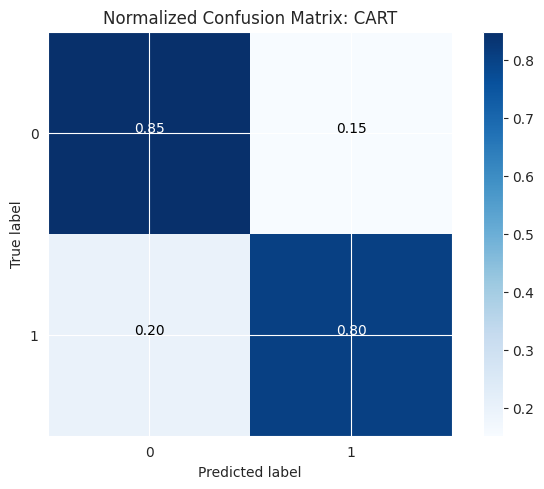

In [24]:
y_pred = rf2.predict(X_test)
f1 = round(f1_score(y_val, y_pred), 3)
accuracy = round(accuracy_score(y_val,y_pred), 3)
precision = round(precision_score(y_val,y_pred), 3)
recall = round(recall_score(y_val,y_pred), 3)
print('MAX DEPTH: {} / # N EST: {} -- F1: {} / Accuracy: {} / Precision: {} / Recall: {}'.format(rf2.max_depth,
                                                                         rf2.max_leaf_nodes,
                                                                         f1,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_pred),
                      classes=class_names, normalize = True,
                      title='Normalized Confusion Matrix: CART')

Palabras más relevantes a la hora de predecir la clase correcta.

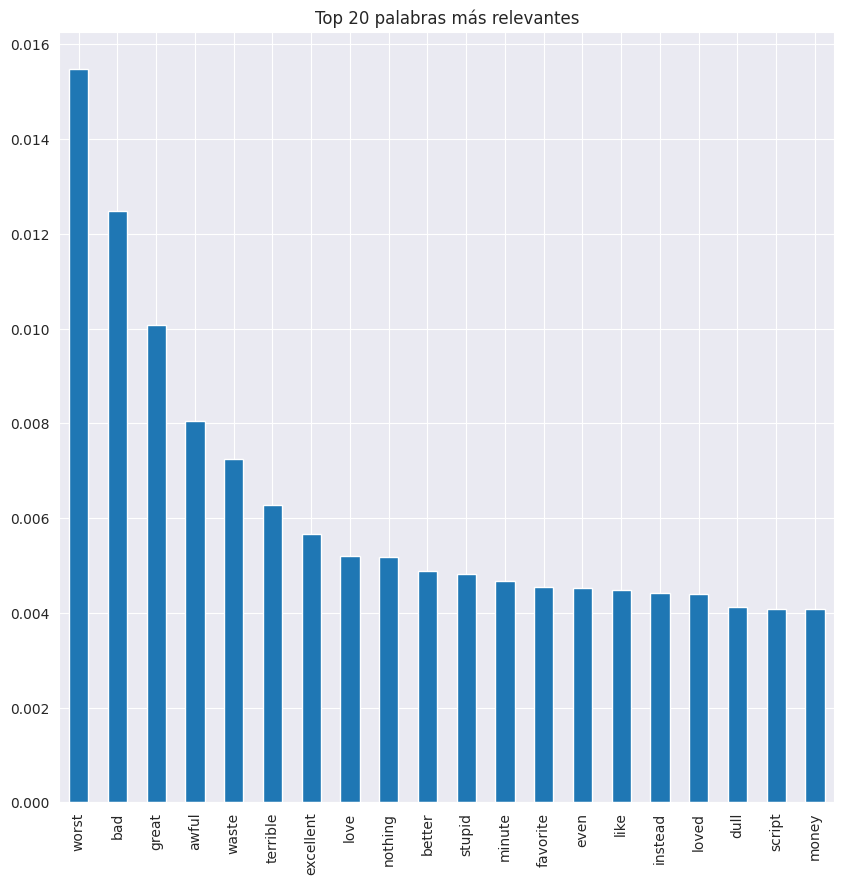

In [25]:
feat_importances = pd.Series(rf2.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 palabras más relevantes")
plt.show()